In [1]:
import warnings
warnings.simplefilter("ignore")

#  <font color='#F5BCA9 '> Proyecto MRI Alzheimer: Un estudios de clasificación   </font>
### Base de Datos: Best Alzheimer MRI dataset

#####  <font color='#F5BCA9 '> Realizado por: Ixchel Dafne Avendaño Pacheco  </font>

##### Matricula: 23265456


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFldIXEg4afBFSl_FVh0gJNyQCqz95iqimQpKJGQpBA45hMk2O-MCmvpLKy2rtQr78XEA&usqp=CAU" alt="A la izquierda se muestra un corte coronal de un cerebro sano, a la derecha se muestra un corte coronal de un cerebro con la enfermedad de Alzheimer" width="680" height="880" />

Importamos las librerias necesarias 

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import cv2 
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import visualkeras
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report

##  <font color='#F5BCA9 '> Análisis Exploratorio  </font> 

En la siguiente linea creamos la ruta para obtener las imagenes

In [3]:
data_train = os.getcwd() + "/mri"

Cargamos las imágenes 

In [4]:
images_train = []
labels_train = []
for category in os.listdir(data_train):
    category_dir = os.path.join(data_train, category)
    for image_file in os.listdir(category_dir):
        image_train = cv2.imread(os.path.join(category_dir, image_file))
        image_train = cv2.resize(image_train, (128, 128))  
        images_train.append(image_train)
        labels_train.append(category)

Modificamos las imagenes a un formato que sea compatible con TensorFlow

In [5]:
images_train = np.array(images_train)
images_train = images_train.astype(np.float32)

Normalizamos los datos de la imagen al rango [0..1] antes de mostrar las imágenes. 

In [6]:
images_train = images_train / 255.

Creamos una variable para que sea aleatoria entre los valores de las imagenes para poder representar 25 de ellas al azar

In [7]:
indexs = randint(0, len(images_train), 25)

Imrpimimos 25 imagenes de manera aleaotoria 

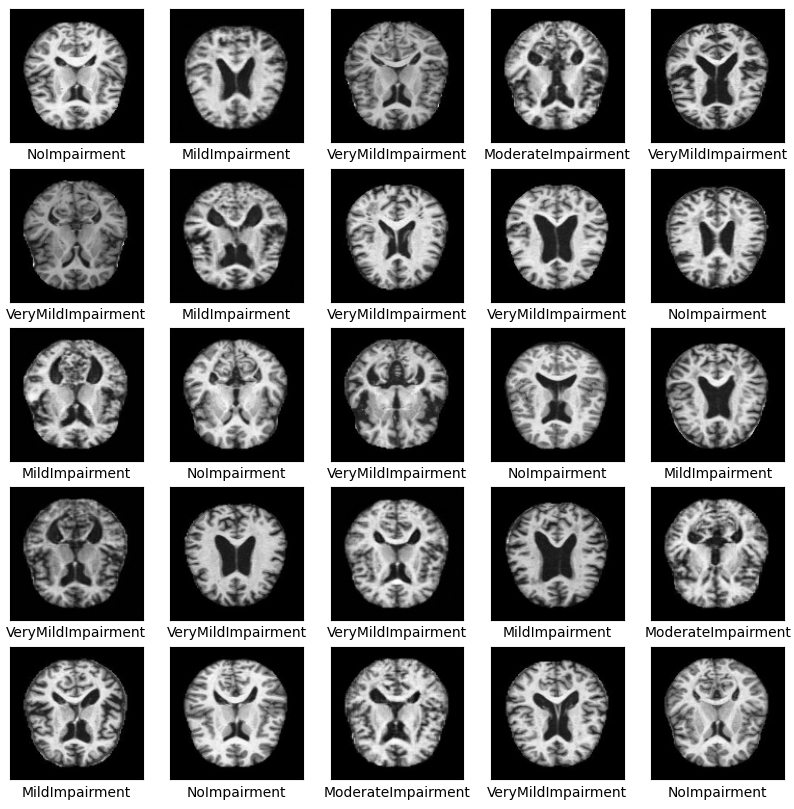

In [8]:
plt.figure(figsize=(10,10))
for i, j in zip(range(25), indexs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[j])
    plt.xlabel(labels_train[j])
plt.show() 

Las 25 imágenes mostradas presentan una resolución adecuada para ser utilizadas en una red neuronal convolucional. Esta resolución permite que la red aprenda los detalles de las imágenes, lo cual es importante para realizar tareas de clasificación o detección.

Además, la visualización de las imágenes proporciona una visión general de lo que realizará la red neuronal convolucional. Esto permite  comprender mejor el funcionamiento de la red y realizar los ajustes necesarios para mejorar su rendimiento.

##  <font color='#F5BCA9 '> Preprocesamiento  </font> 

A continuación se hará un preprocesamiento de las imágenes, este consiste en:
1. Reescalar los pixeles de las imágenes para que se encuentre entre 0 y 1 
2. Aplicar aleatoriamente una transformación de sesgo a las imágenes, la cual inclina una imagen en una dirección determinada
3. Aplicar aleatoriamente una transformación de zoom a las imágenes.
4. Dividir los datos en un conjunto de entrenamiento y un conjunto de validación. El conjunto de validación consiste  del 20% de los datos.

In [9]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  #Nos dale 20% de nuestro total de imagenes el cual es 291 imagenes 
)

Además de ello realizamos la carga de las imágenes desde la carpeta mri

In [10]:
data_path = "./mri/"

Notemos que se encuentran 11505 imagenes dividas en 4 clases las cuales corresponden a: Deterioro Cognitivo leve,Deterioro Cognitivo Moderado, Sin deterioro, Deterioro Cognitvo Alto 


MildImpairment, ModerateImpairment, NoImpairment, VeryMildImpairment

In [11]:
data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),  
    batch_size=32,         
    class_mode='categorical',
    classes=['MildImpairment','ModerateImpairment','NoImpairment','VeryMildImpairment'] 
)

Found 11505 images belonging to 4 classes.


##  <font color='#F5BCA9 '> Conjunto de entrenamiento y validación   </font>

A continuación, se generan dos conjuntos uno que se usará para el entrenamiento y otro que se usará para la validación. Además, recordar que para el conjunto de entrenamiento se usara el 80% de los datos, mientras que para el conjunto de validación se usara el 20%
###  <font color='#F5BCA9 '> Conjunto de entrenamiento    </font>

Ya que el total de las imágenes corresponde a 11,505, para el conjunto de entrenamiento se tendrán 9,205, el cual es el 80% de las imágenes 

In [12]:
train_data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=8,
    subset='training',
    class_mode='categorical',
    classes=['MildImpairment','ModerateImpairment','NoImpairment','VeryMildImpairment']
)

Found 9205 images belonging to 4 classes.


###  <font color='#F5BCA9 '> Conjunto de validación   </font>

De manera similar, de las 11,505 imágenes se usarán 2,300 para el conjunto de validación las cuales corresponden al 20% del total de las muestras 


In [13]:
test_data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=1,
    subset='validation',
    class_mode='categorical',
    classes=['MildImpairment','ModerateImpairment','NoImpairment','VeryMildImpairment']   
)

Found 2300 images belonging to 4 classes.


##  <font color='#F5BCA9 '> Red Neuronal Convolucional   </font>

Definimos la red neuronal convolucional (CNN) utilizando la biblioteca Keras. La CNN consta de las siguientes capas: Capa convolucional 1, Capa de pooling máximo 1, Capa convolucional 2, Capa de pooling máximo 2, Capa convolucional 3, Capa plana, Capa densa 1  y Capa densa 2 (capa de salida)


Capa convolucional 1:

1. Esta capa aplica 32 filtros de tamaño 3x3 a la imagen de entrada.
1. La función de activación utilizada es 'relu', que introduce no linealidad en la red.
2. La forma de entrada de la imagen se especifica como (64, 64, 3), lo que indica que la imagen tiene una altura de 64 píxeles, un ancho de 64 píxeles y 3 canales (RGB).

Capa de pooling máximo 1:

1. Esta capa reduce las dimensiones espaciales de los mapas de características en un factor de 2 tanto en altura como en ancho.
2. Esto ayuda a reducir el costo computacional y controlar el sobreajuste.

Capa convolucional 2:

1. Esta capa aplica 64 filtros de tamaño 3x3 a los mapas de características de la capa anterior.
2. La función de activación utilizada sigue siendo 'relu'.

Capa de pooling máximo 2:

1. Similar a la primera capa de pooling máximo, esta capa reduce aún más las dimensiones espaciales de los mapas de características.

Capa convolucional 3:

1. Esta capa aplica otros 64 filtros de tamaño 3x3 a los mapas de características de la capa anterior.
2. La función de activación utilizada sigue siendo 'relu'.

Capa plana:

1. Esta capa convierte los mapas de características 2D en un vector 1D.
2. Esto es necesario antes de alimentar los datos en una capa completamente conectada.

Capa densa 1:

1. Esta capa es una capa completamente conectada con 64 neuronas.
2. La función de activación utilizada es 'relu'.

Capa densa 2 (capa de salida):

1. Esta capa es la capa de salida final de la CNN.
2. Tiene 4 neuronas, que corresponden a las 4 clases posibles 
3. La función de activación utilizada es 'softmax', que normaliza los valores de salida en probabilidades entre 0 y 1.

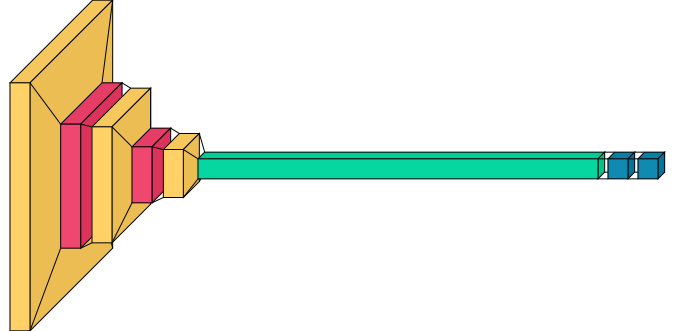

In [14]:
CNN = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(4,activation='softmax')
])

visualkeras.layered_view(CNN)

Compilamos el modelo

In [15]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##  <font color='#F5BCA9 '> Red Neuronal Convolucional 5 épocas  </font>

En este caso, la red neuronal convolucional tendrá 5 épocas. Esto significa que se entrenará con el conjunto de datos de imágenes durante 5 iteraciones. Cada época, la red neuronal aprenderá los patrones en las imágenes y mejorará su rendimiento.

In [16]:
history = CNN.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
1151/1151 [==============================] - 140s 120ms/step - loss: 0.9237 - accuracy: 0.5585 - val_loss: 0.7449 - val_accuracy: 0.6713
Epoch 2/5
1151/1151 [==============================] - 78s 68ms/step - loss: 0.5850 - accuracy: 0.7413 - val_loss: 0.5640 - val_accuracy: 0.7226
Epoch 3/5
1151/1151 [==============================] - 79s 68ms/step - loss: 0.4905 - accuracy: 0.7836 - val_loss: 0.5858 - val_accuracy: 0.7343
Epoch 4/5
1151/1151 [==============================] - 77s 67ms/step - loss: 0.4391 - accuracy: 0.8101 - val_loss: 0.4750 - val_accuracy: 0.7843
Epoch 5/5
1151/1151 [==============================] - 77s 67ms/step - loss: 0.3956 - accuracy: 0.8268 - val_loss: 0.4479 - val_accuracy: 0.7939


In [17]:
CNN.evaluate(test_data)

2300/2300 [==============================] - 17s 7ms/step - loss: 0.4395 - accuracy: 0.8061


[0.43945810198783875, 0.8060869574546814]


###  <font color='#F5BCA9 '> Resultados de clasificación de CNN 5 épocas </font>



In [18]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

2300/2300 [==============================] - 15s 6ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       545
           1       1.00      1.00      1.00       514
           2       0.72      0.77      0.74       640
           3       0.66      0.62      0.64       601

    accuracy                           0.80      2300
   macro avg       0.81      0.81      0.81      2300
weighted avg       0.80      0.80      0.80      2300




###  <font color='#F5BCA9 '> Matriz de  Confusión   5 épocas</font>

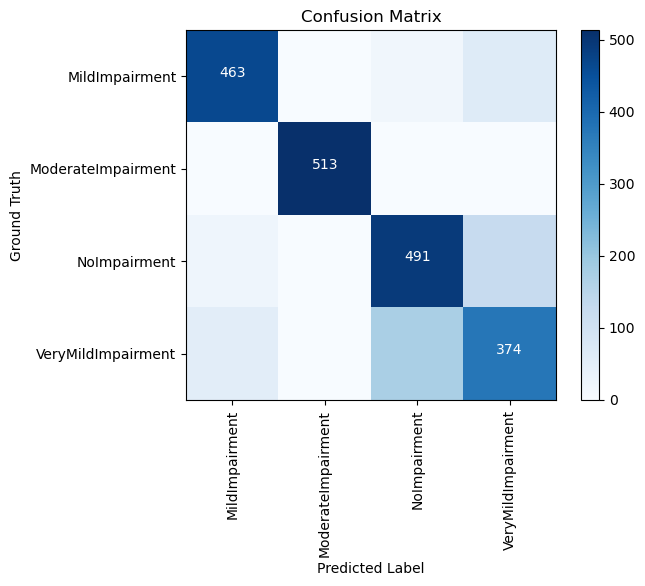

In [19]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()


###  <font color='#F5BCA9 '> Real vs Predicción  5  épocas </font>

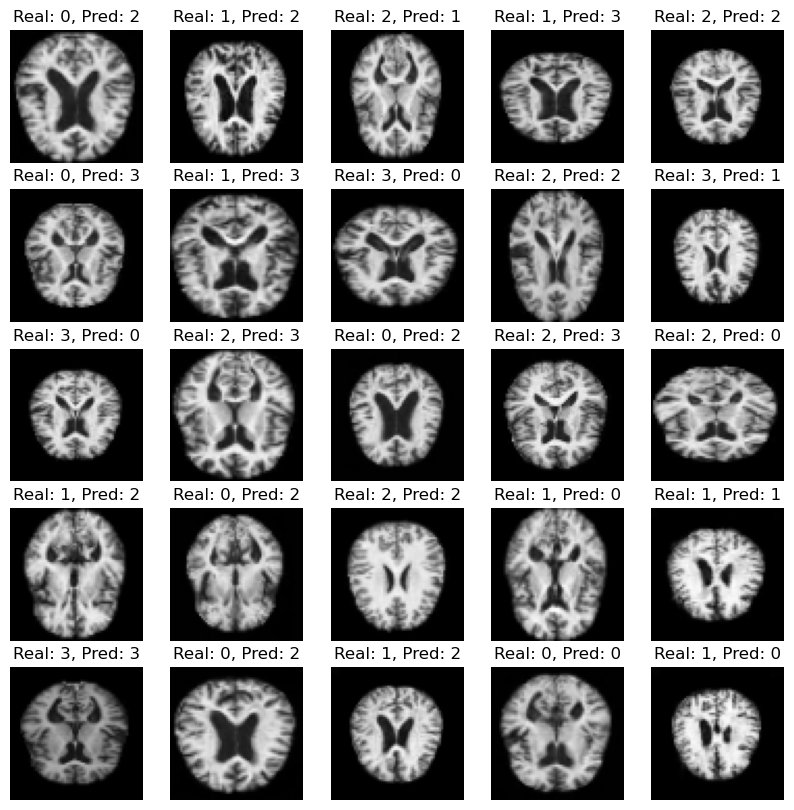

In [20]:

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()


###  <font color='#F5BCA9 '> Gráfica de pérdida 5 épocas </font>

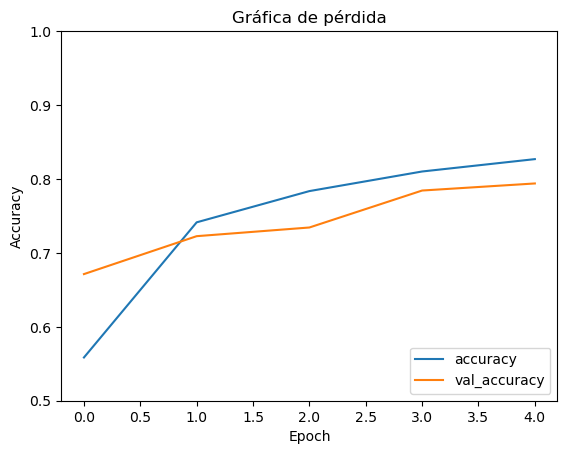

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

###  <font color='#F5BCA9 '> Resultados 5 épocas  </font>


En general, los resultados del entrenamiento de la CNN con 5 épocas son prometedores, con una precisión general del 80%. La precisión y la F1-score son altas para las clases Deterioro Cognitivo leve,Deterioro Cognitivo Moderado, Sin deterioro, lo que indica que el modelo es capaz de clasificar correctamente las imágenes de estas clases con un alto grado de precisión. Sin embargo, la precisión y la F1-score son ligeramente más bajas para la clase Deterioro Cognitvo Alto, lo que sugiere que el modelo puede tener alguna dificultad para identificar correctamente las imágenes de esta clase.




Una vez que obtuvimos el acurracy, el cual corresponde a:  <font color='red'> 0.80  </font> con 5 épocas procedemos a realizar el entrenamiento del modelo con 10 épocas 


##  <font color='#F5BCA9 '> Red Neuronal Convolucional 10 épocas  </font>

En este caso, la red neuronal convolucional tendrá 10 épocas. Al aumentar el número de épocas a 10, la red neuronal tendrá más oportunidades de aprender los patrones en las imágenes. Esto podría mejorar el rendimiento de la red neuronal y hacerla más precisa a la hora de clasificar las imágenes de RMI.



In [22]:
history = CNN.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
1151/1151 [==============================] - 79s 68ms/step - loss: 0.3578 - accuracy: 0.8490 - val_loss: 0.4375 - val_accuracy: 0.8061
Epoch 2/10
1151/1151 [==============================] - 79s 68ms/step - loss: 0.3260 - accuracy: 0.8603 - val_loss: 0.4797 - val_accuracy: 0.8052
Epoch 3/10
1151/1151 [==============================] - 80s 69ms/step - loss: 0.3014 - accuracy: 0.8715 - val_loss: 0.3903 - val_accuracy: 0.8391
Epoch 4/10
1151/1151 [==============================] - 78s 68ms/step - loss: 0.2759 - accuracy: 0.8859 - val_loss: 0.3705 - val_accuracy: 0.8430
Epoch 5/10
1151/1151 [==============================] - 74s 64ms/step - loss: 0.2499 - accuracy: 0.8983 - val_loss: 0.3875 - val_accuracy: 0.8413
Epoch 6/10
1151/1151 [==============================] - 54s 47ms/step - loss: 0.2379 - accuracy: 0.9023 - val_loss: 0.3635 - val_accuracy: 0.8587
Epoch 7/10
1151/1151 [==============================] - 59s 51ms/step - loss: 0.2205 - accuracy: 0.9104 - val_loss: 0.3342 -

In [23]:
CNN.evaluate(test_data)

2300/2300 [==============================] - 9s 4ms/step - loss: 0.3164 - accuracy: 0.8743


[0.31636306643486023, 0.8743478059768677]


###  <font color='#F5BCA9 '> Resultados de clasificación de CNN  10 épocas </font>



In [24]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

2300/2300 [==============================] - 8s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       545
           1       1.00      1.00      1.00       514
           2       0.83      0.86      0.84       640
           3       0.80      0.81      0.80       601

    accuracy                           0.89      2300
   macro avg       0.89      0.89      0.89      2300
weighted avg       0.89      0.89      0.89      2300




###  <font color='#F5BCA9 '> Matriz de  Confusión  10 épocas</font>

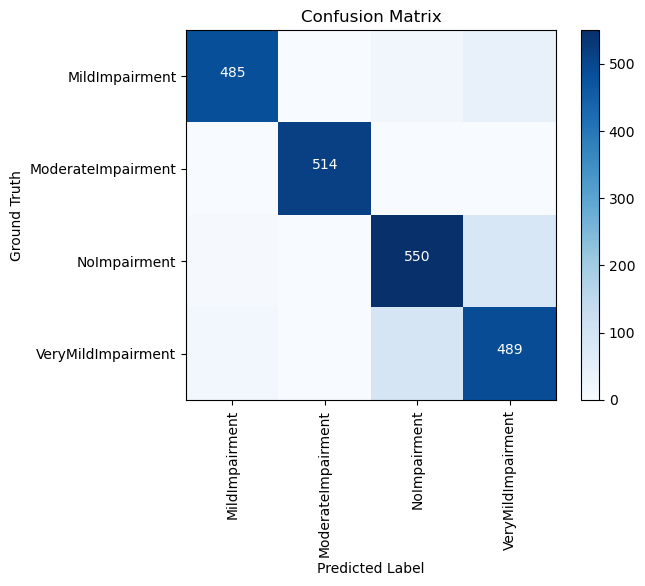

In [25]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()


###  <font color='#F5BCA9 '> Real vs Predicción 10 épocas</font>

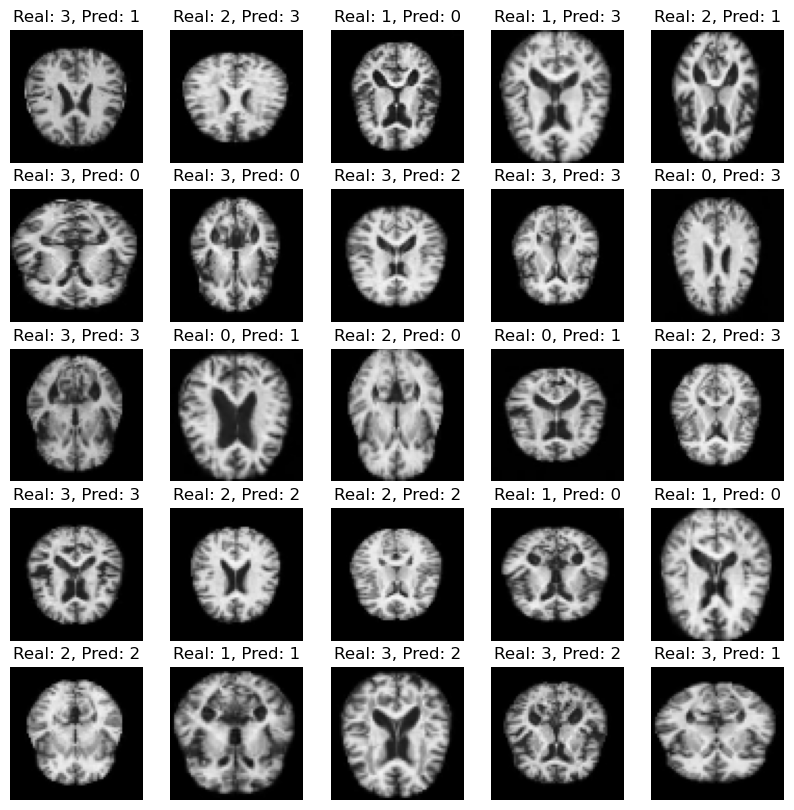

In [26]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()


###  <font color='#F5BCA9 '> Gráfica de pérdida 10  épocas </font>

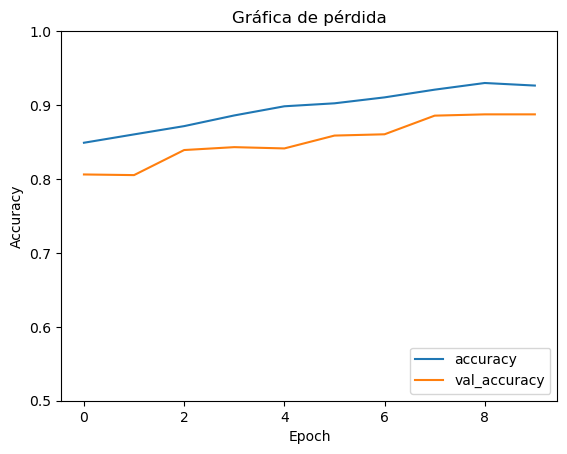

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

Una vez que obtuvimos el acurracy, el cual corresponde a:  <font color='red'> 0.89  </font> con 10 épocas procedemos a realizar el entrenamiento del modelo con 15 épocas 

###  <font color='#F5BCA9 '> Resultados 10 épocas  </font>


Los resultados del entrenamiento de la CNN con 10 épocas son muy buenos, con una precisión general del 89%. La precisión y la F1-score son altas para las cuatro clases, lo que indica que el modelo es capaz de clasificar correctamente las imágenes de estas clases con un alto grado de precisión.

En comparación con los resultados del entrenamiento con 5 épocas, la precisión y la F1-score para todas las clases han mejorado ligeramente. En particular, la precisión y la F1-score para la clase 3 'Sin deterioro' 
han mejorado de 0.66 a 0.80, lo que sugiere que el modelo ahora es capaz de clasificar correctamente las imágenes de esta clase con mayor precisión.

Una posible explicación para esta mejora es que el entrenamiento con 10 épocas ha permitido al modelo aprender características más discriminativas para cada clase. Esto podría haber ayudado al modelo a diferenciar mejor las imágenes de la clase 3 de las imágenes de las otras clases.

En general, los resultados del entrenamiento actual son muy alentadores y sugieren que el modelo tiene el potencial de clasificar imágenes de las cuatro clases con un alto grado de precisión. Con algunas mejoras, el modelo podría ser aún más preciso, especialmente en la clase 3.





##  <font color='#F5BCA9 '> Red Neuronal Convolucional 15 épocas  </font>

En este caso, la red neuronal convolucional tendrá 15 épocas. Al aumentar el número de épocas a 10, la red neuronal tendrá más oportunidades de aprender los patrones en las imágenes. Al final del entrenamiento, la red neuronal podrá clasificar las imágenes de RMI con mayor precisión que con 5 o 10 épocas de entrenamiento. 

In [28]:
history = CNN.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
1151/1151 [==============================] - 52s 46ms/step - loss: 0.1722 - accuracy: 0.9296 - val_loss: 0.3200 - val_accuracy: 0.8757
Epoch 2/15
1151/1151 [==============================] - 53s 46ms/step - loss: 0.1617 - accuracy: 0.9351 - val_loss: 0.2393 - val_accuracy: 0.9096
Epoch 3/15
1151/1151 [==============================] - 61s 53ms/step - loss: 0.1517 - accuracy: 0.9420 - val_loss: 0.2249 - val_accuracy: 0.9161
Epoch 4/15
1151/1151 [==============================] - 59s 52ms/step - loss: 0.1500 - accuracy: 0.9409 - val_loss: 0.2476 - val_accuracy: 0.9052
Epoch 5/15
1151/1151 [==============================] - 70s 61ms/step - loss: 0.1434 - accuracy: 0.9452 - val_loss: 0.3178 - val_accuracy: 0.8839
Epoch 6/15
1151/1151 [==============================] - 60s 52ms/step - loss: 0.1387 - accuracy: 0.9466 - val_loss: 0.2269 - val_accuracy: 0.9091
Epoch 7/15
1151/1151 [==============================] - 67s 58ms/step - loss: 0.1267 - accuracy: 0.9508 - val_loss: 0.2547 -

In [29]:
CNN.evaluate(test_data)

2300/2300 [==============================] - 8s 4ms/step - loss: 0.2234 - accuracy: 0.9126


[0.22337684035301208, 0.9126086831092834]

Observamos que con 15 épocas, la red neuronal obtuvo un accuracy de  <font color='red'> 0.92  </font>, lo que significa que clasificó correctamente el 92% de las imágenes. Con 10 épocas, la red neuronal obtuvo un accuracy de 0.86, y con 5 épocas, un accuracy de 0.77.

Estos resultados muestran que entrenar la red neuronal con 15 épocas mejora su capacidad para aprender los patrones en las imágenes de RMI. Esto se traduce en una mayor precisión a la hora de clasificar las imágenes


##  <font color='#F5BCA9 '> Resultados de clasificación de CNN  </font>



In [30]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

2300/2300 [==============================] - 8s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       545
           1       1.00      1.00      1.00       514
           2       0.90      0.88      0.89       640
           3       0.85      0.89      0.87       601

    accuracy                           0.92      2300
   macro avg       0.92      0.92      0.92      2300
weighted avg       0.92      0.92      0.92      2300




###  <font color='#F5BCA9 '> Matriz de  Confusión 15 épocas
</font>

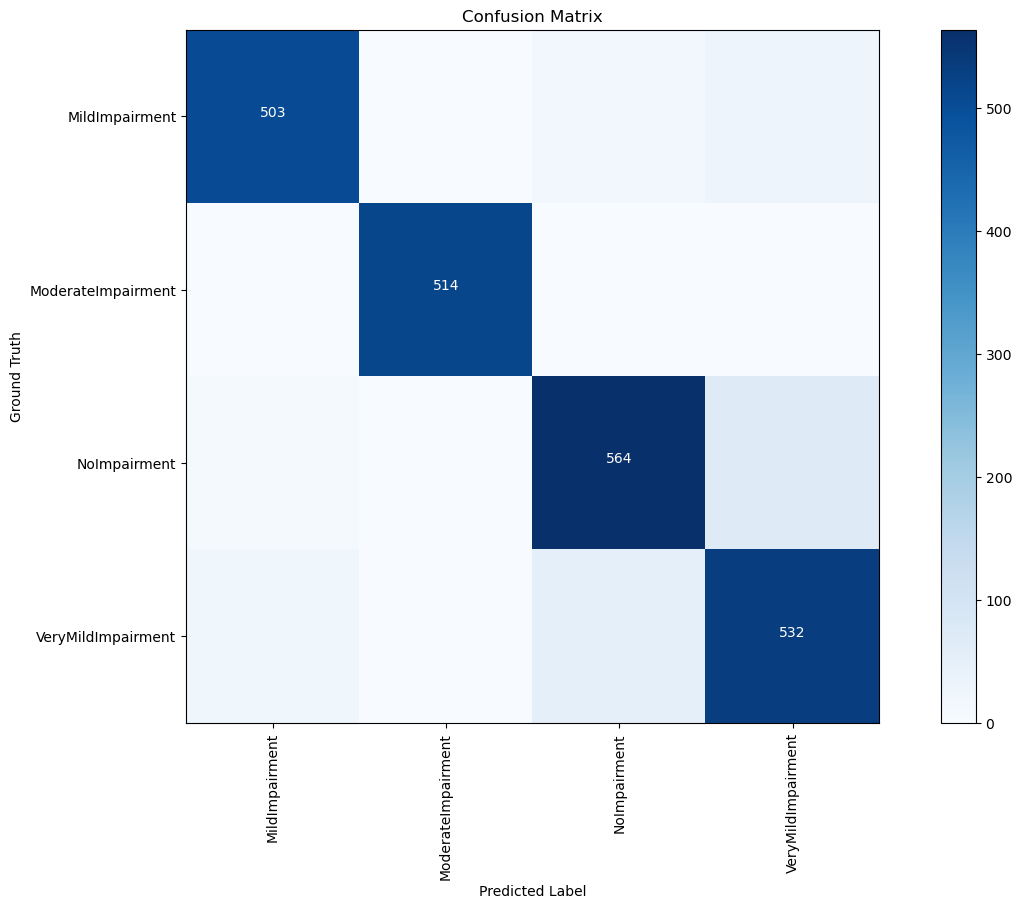

In [31]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()


###  <font color='#F5BCA9 '> Real vs Predicción 15 épocas</font>

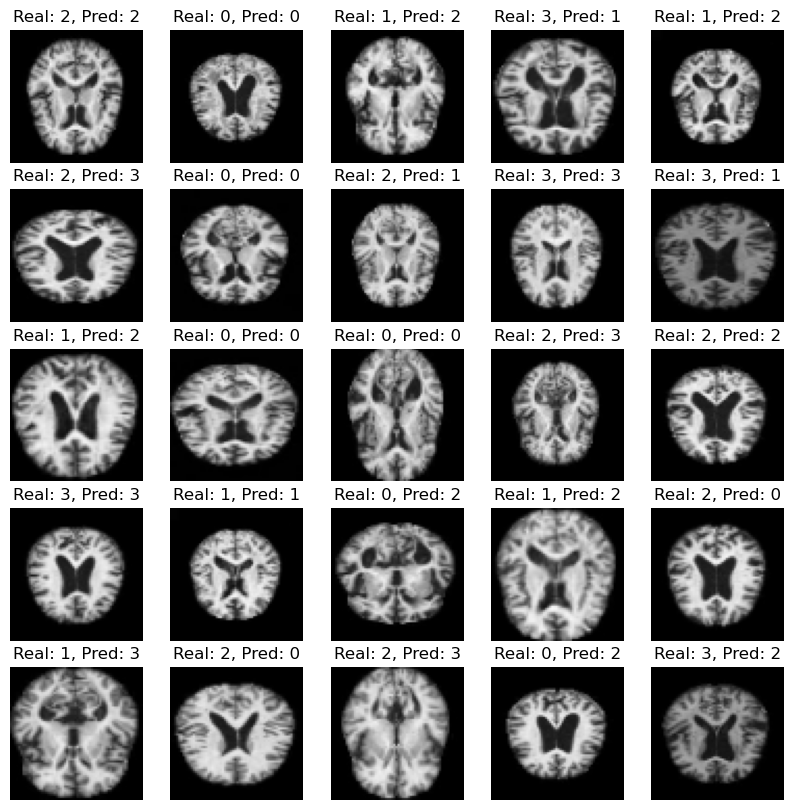

In [32]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()


###  <font color='#F5BCA9 '> Gráfica de pérdida 15 épocas </font>

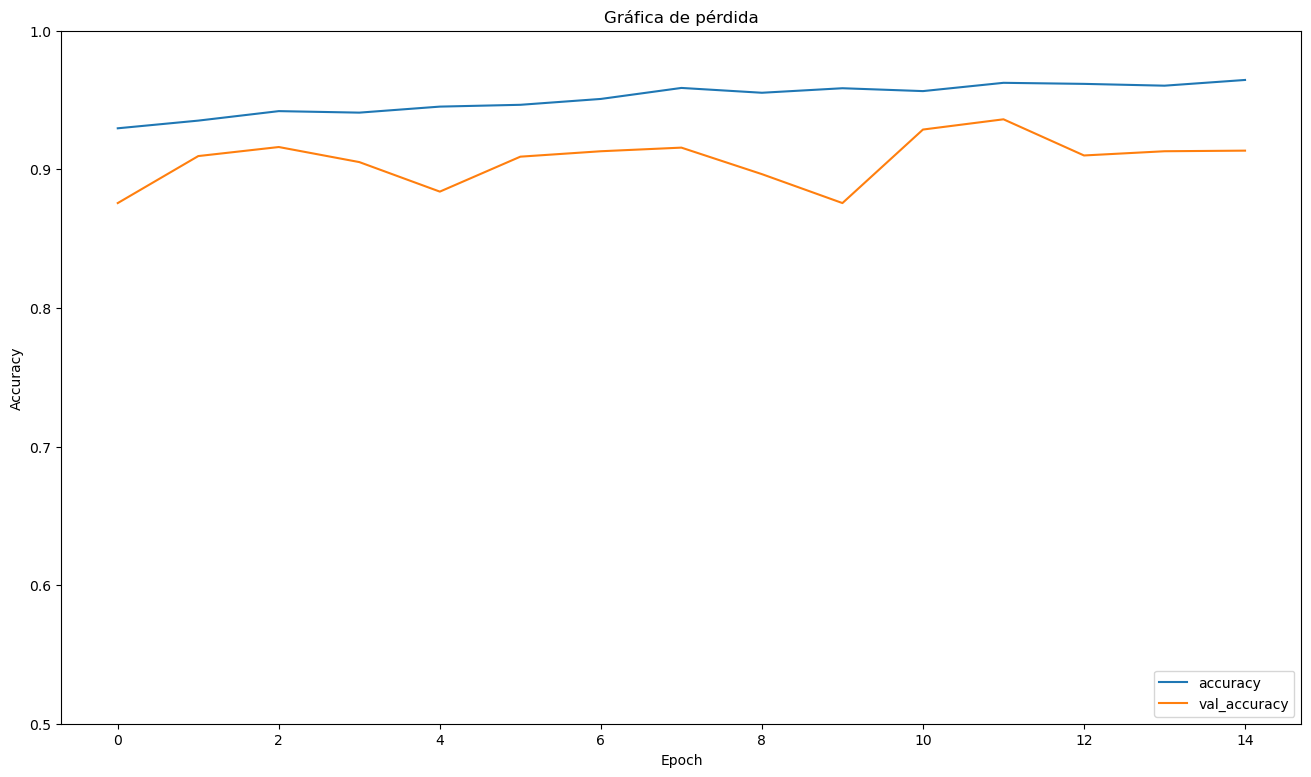

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

###  <font color='#F5BCA9 '> Resultados 15 épocas  </font>

Los resultados del entrenamiento de la CNN con 15 épocas son aún más impresionantes que los resultados anteriores. La precisión general ha aumentado al 92%, y la precisión y la F1-score han aumentado para todas las clases. Esto sugiere que el modelo ha aprendido a clasificar las imágenes de las cuatro clases con un alto grado de precisión.

El aumento en la precisión y la F1-score para la clase 3 'Sin deterioro' es particularmente notable. La precisión ha aumentado de 0.66 a 0.85, y la F1-score ha aumentado de 0.64 a 0.87. Esto sugiere que el modelo ahora es capaz de clasificar correctamente las imágenes de esta clase con una precisión muy alta.

Es probable que el aumento en el rendimiento se deba a que el entrenamiento con 15 épocas ha permitido al modelo aprender características aún más discriminativas para cada clase. Esto podría haber ayudado al modelo a diferenciar mejor las imágenes de la clase 3 de las imágenes de las otras clases.

En general, los resultados del entrenamiento actual son excepcionales y sugieren que el modelo tiene el potencial de ser una herramienta muy valiosa para la clasificación de imágenes. Es poco probable que se obtengan mejoras significativas con más épocas de entrenamiento, por lo que se decide quedarse con este número de épocas.



##  <font color='#F5BCA9 '> Conclusión  </font>

Los resultados del entrenamiento de una red neuronal convolucional (CNN) para la clasificación de imágenes de resonancia magnética (RM) de cuatro clases de deterioro cognitivo (DC) son prometedores. Con 5 épocas de entrenamiento, la CNN obtuvo una precisión general del 80%. Con 10 épocas de entrenamiento, la precisión general aumentó al 89%. Con 15 épocas de entrenamiento, la precisión general aumentó aún más al 92%.

Estos resultados sugieren que el aumento en el número de épocas de entrenamiento conduce a un aumento en el rendimiento de la CNN. En particular, la precisión de la clase de deterioro cognitivo alto (DCA) aumentó de 0.66 a 0.85 con 15 épocas de entrenamiento. Esto sugiere que la CNN ahora es capaz de clasificar correctamente las imágenes de esta clase con una precisión muy alta.

Estos resultados sugieren que la CNN tiene el potencial de ser una herramienta valiosa para la detección y diagnóstico del deterioro cognitivo, especialmente del deterioro cognitivo alto, que es una etapa temprana de la enfermedad de Alzheimer.


Estas técnicas, se podrían realizar los siguientes estudios para validar los resultados y mejorar la utilidad de la CNN para la detección y diagnóstico del Alzheimer:

1. Validar los resultados en un conjunto de datos más grande y diverso. Esto ayudaría a garantizar que los resultados no sean solo una coincidencia.
2. Estudiar la relación entre las características de las imágenes de RM y las diferentes etapas del Alzheimer. Esto podría ayudar a mejorar la comprensión de la enfermedad y el desarrollo de nuevas terapias.
3. Desarrollar una interfaz de usuario fácil de usar para la CNN. Esto facilitaría la implementación de la CNN en el entorno clínico.

Con estas investigaciones adicionales, la CNN podría tener el potencial de ser una herramienta valiosa para el diagnóstico temprano del Alzheimer y la evaluación de la progresión de la enfermedad.

Impacto potencial

El diagnóstico temprano del Alzheimer es crucial para mejorar los resultados del tratamiento y la calidad de vida de las personas con la enfermedad. El uso de la CNN para la detección y diagnóstico del Alzheimer podría ayudar a los médicos a identificar la enfermedad en sus primeras etapas, cuando es más probable que el tratamiento sea eficaz.

Además, la CNN podría usarse para evaluar la progresión de la enfermedad. Esto podría ayudar a los médicos a desarrollar planes de tratamiento personalizados para cada paciente.

En general, la CNN tiene el potencial de ser una herramienta valiosa para el diagnóstico y tratamiento del Alzheimer.

